# Multiple changepoint detection and Bayesian model selection


In [0]:
#@title Licensed under the Apache License, Version 2.0 (the "License"); { display-mode: "form" }
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Multiple_changepoint_detection_and_Bayesian_model_selection.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Multiple_changepoint_detection_and_Bayesian_model_selection.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

## Imports

In [0]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd

from matplotlib import pylab as plt
%matplotlib inline
import scipy.stats

##  Task: changepoint detection with multiple changepoints

Consider a changepoint detection task:  events happen at a rate that changes over time, driven by sudden shifts in the (unobserved) state of some system or process generating the data.

For example, we might observe a series of counts like the following:

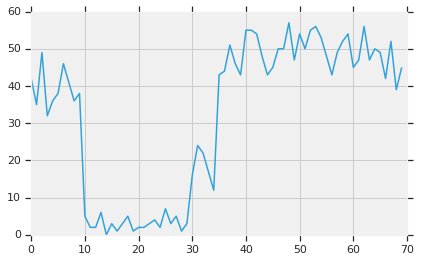

In [0]:
true_rates = [40, 3, 20, 50]
true_durations = [10, 20, 5, 35]

observed_counts = np.concatenate([
  scipy.stats.poisson(rate).rvs(num_steps)
    for (rate, num_steps) in zip(true_rates, true_durations)
]).astype(np.float32)

plt.plot(observed_counts)

These could represent the number of failures in a datacenter, number of visitors to a webpage, number of packets on a network link, etc.

Note it's not entirely apparent how many distinct system regimes there are just from looking at the data. Can you tell where each of the three switchpoints occurs?

## Known number of states

We'll first consider the (perhaps unrealistic) case where the number of unobserved states is known a priori. Here, we'd assume we know there are four latent states.

We model this problem as a switching (inhomogeneous) Poisson process: at each point in time, the number of events that occur is Poisson distributed, and the *rate* of events is determined by the unobserved system state $z_t$:

$$x_t \sim \text{Poisson}(\lambda_{z_t})$$

The latent states are discrete: $z_t \in \{1, 2, 3, 4\}$, so $\lambda = [\lambda_1, \lambda_2, \lambda_3, \lambda_4]$ is a simple vector containing a Poisson rate for each state. To model the evolution of states over time, we'll define a simple transition model $p(z_t | z_{t-1})$: let's say that at each step we stay in the previous state with some probability $p$, and with probability $1-p$ we transition to a different state uniformly at random. The initial state is also chosen uniformly at random, so we have:

$$
\begin{align*}
z_1 &\sim \text{Categorical}\left(\left\{\frac{1}{4}, \frac{1}{4}, \frac{1}{4}, \frac{1}{4}\right\}\right)\\
z_t | z_{t-1} &\sim \text{Categorical}\left(\left\{\begin{array}{cc}p & \text{if } z_t = z_{t-1} \\ \frac{1-p}{4-1} & \text{otherwise}\end{array}\right\}\right)
\end{align*}$$

These assumptions correspond to a [hidden Markov model](http://mlg.eng.cam.ac.uk/zoubin/papers/ijprai.pdf) with Poisson emissions. We can encode them in TFP using `tfd.HiddenMarkovModel`. First, we define the transition matrix and the uniform prior on the initial state:

In [0]:
num_states = 4

initial_state_logits = np.zeros([num_states], dtype=np.float32) # uniform distribution

daily_change_prob = 0.05
transition_probs = daily_change_prob / (num_states-1) * np.ones(
    [num_states, num_states], dtype=np.float32)
np.fill_diagonal(transition_probs,
                 1-daily_change_prob)

print("Initial state logits:\n{}".format(initial_state_logits))
print("Transition matrix:\n{}".format(transition_probs))

Initial state logits:
[ 0.  0.  0.  0.]
Transition matrix:
[[ 0.94999999  0.01666667  0.01666667  0.01666667]
 [ 0.01666667  0.94999999  0.01666667  0.01666667]
 [ 0.01666667  0.01666667  0.94999999  0.01666667]
 [ 0.01666667  0.01666667  0.01666667  0.94999999]]


Next, we build a `tfd.HiddenMarkovModel` distribution, using a trainable variable to represent the rates associated with each system state. We parameterize the rates in log-space to ensure they are positive-valued.

In [0]:
tf.reset_default_graph()

# Define variable to represent the unknown log rates.
trainable_rates = tf.exp(tf.get_variable(
    'log_rates', initializer=(
        np.log(np.mean(observed_counts)) + tf.random_normal([num_states]))))

hmm = tfd.HiddenMarkovModel(
  initial_distribution=tfd.Categorical(
      logits=initial_state_logits),
  transition_distribution=tfd.Categorical(probs=transition_probs),
  observation_distribution=tfd.Poisson(trainable_rates),
  num_steps=len(observed_counts))

Finally, we define the model's total log density, including a weakly-informative LogNormal prior on the rates, and run an optimizer to compute the [maximum a posteriori](https://en.wikipedia.org/wiki/Maximum_a_posteriori_estimation) (MAP) fit to the observed count data.

In [0]:
rate_prior = tfd.LogNormal(5, 5)
total_log_prob = (
    tf.reduce_sum(rate_prior.log_prob(trainable_rates)) +
    hmm.log_prob(observed_counts))

train_op = tf.train.AdamOptimizer(0.1).minimize(-total_log_prob)

In [0]:
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())

  for step in range(201):
    _, loss_, rates_ = sess.run((train_op, total_log_prob, trainable_rates))

    if step % 20 == 0:
      print("step {}: log prob {} rates {}".format(step, loss_, rates_))

print("Inferred rates: {}".format(rates_))
print("True rates: {}".format(true_rates))

step 0: log prob -531.548522949 rates [ 34.28146362  33.39609146  23.77467155  52.43385696]
step 20: log prob -256.470306396 rates [ 48.83695602  27.72482109   5.04360199  46.49458694]
step 40: log prob -232.297744751 rates [ 48.91260529  17.41979027   2.83147216  41.95743942]
step 60: log prob -231.924530029 rates [ 49.07848358  16.92751884   2.68086982  40.23476791]
step 80: log prob -231.406188965 rates [ 49.08480072  18.099123     2.87654066  39.47866821]
step 100: log prob -231.385375977 rates [ 49.04584503  18.16383362   2.97647762  39.24641418]
step 120: log prob -231.381027222 rates [ 49.06874847  18.06420517   2.97097301  39.32009888]
step 140: log prob -231.380187988 rates [ 49.06266403  18.02622032   2.95641661  39.35654449]
step 160: log prob -231.380187988 rates [ 49.06277084  18.01802635   2.95617914  39.33675766]
step 180: log prob -231.379974365 rates [ 49.06337738  18.01685715   2.95807815  39.34206772]
step 200: log prob -231.380126953 rates [ 49.06301498  18.01676178

It worked! Note that the latent states in this model are identifiable only up to permutation, so the rates we recovered are in a different order, and there's a bit of noise, but generally they match pretty well.

### Recovering the state trajectory

Now that we've fit the model, we might want to reconstruct *which* state the model believes the system was in at each timestep.

This is a *posterior inference* task: given the observed counts $x_{1:T}$ and model parameters (rates) $\lambda$, we want to infer the sequence of discrete latent variables, following the posterior distribution $p(z_{1:T} | x_{1:T}, \lambda)$. In a hidden Markov model, we can efficiently compute marginals and other properties of this distribution using standard message-passing algorithms such as the [forward-backward algorithm](https://en.wikipedia.org/wiki/Forward%E2%80%93backward_algorithm).

**Coming soon:** support for posterior inference in `tfd.HiddenMarkovModel` is work in progress. We hope to expand this section soon!

## Unknown number of states

In real problems, we may not know the 'true' number of states in the system we're modeling. This may not always be a concern: if you don't particularly care about the identities of the unknown states, you could just run a model with more states than you know the model will need, and learn (something like) a bunch of duplicate copies of the actual states. But let's assume you do care about inferring the 'true' number of latent states.

We can view this as a case of [Bayesian model selection](http://alumni.media.mit.edu/~tpminka/statlearn/demo/): we have a set of candidate models, each with a different number of latent states, and we want to choose the one that is most likely to have generated the observed data. To do this, we compute the marginal likelihood of the data under each model (we could also add a prior on the models themselves, but that won't be necessary in this analysis; the [Bayesian Occam's razor](https://www.cs.princeton.edu/courses/archive/fall09/cos597A/papers/MacKay2003-Ch28.pdf) turns out to be sufficient to encode a preference towards simpler models).

Unfortunately, the true marginal likelihood, which integrates over both the discrete states $z_{1:T}$ and the (vector of) rate parameters $\lambda$, $$p(x_{1:T}) = \int p(x_{1:T}, z_{1:T}, \lambda) dz d\lambda,$$ is not tractable for this model. For convenience, we'll approximate it using a so-called "[empirical Bayes](https://www.cs.ubc.ca/~schmidtm/Courses/540-W16/L19.pdf)" or "type II maximum likelihood" estimate: instead of fully integrating out the (unknown) rate parameters $\lambda$ associated with each system state, we'll optimize over their values:

$$\tilde{p}(x_{1:T}) = \max_\lambda \int p(x_{1:T}, z_{1:T}, \lambda) dz$$

This approximation may overfit, i.e., it will prefer more complex models than the true marginal likelihood would. We could consider more faithful approximations, e.g., optimizing a variational lower bound, or using a Monte Carlo estimator such as [annealed importance sampling](https://www.tensorflow.org/probability/api_docs/python/tfp/mcmc/sample_annealed_importance_chain); these are (sadly) beyond the scope of this notebook. (For more on Bayesian model selection and approximations, chapter 7 of the excellent [Machine Learning: a Probabilistic Perspective
](https://www.cs.ubc.ca/~murphyk/MLbook/) is a good reference.)

In principle, we could do this model comparison simply by rerunning the optimization above many times with different values of `num_states`, but that would be a lot of work. Here we'll show how to consider multiple models in parallel, using TFP's `batch_shape` mechanism for vectorization.

**Transition matrix and initial state prior**: rather than building a single model description, now we'll build a *batch* of transition matrices and prior logits, one for each candidate model up to `max_num_states`. For easy batching we'll need to ensure that all computations have the same 'shape': this must correspond to the dimensions of the largest model we'll fit. To handle smaller models, we can  'embed' their descriptions in the topmost dimensions of the state space, effectively treating the remaining dimensions as dummy states that are never used.

In [0]:
max_num_states = 10

def build_latent_state(num_states, max_num_states, daily_change_prob=0.05):

  # Give probability exp(-100) ~= 0 to states outside of the current model.
  initial_state_logits = -100. * np.ones([max_num_states], dtype=np.float32)
  initial_state_logits[:num_states] = 0.

  # Build a transition matrix that transitions only within the current
  # `num_states` states.
  transition_probs = np.eye(max_num_states, dtype=np.float32)
  if num_states > 1:
    transition_probs[:num_states, :num_states] = (
        daily_change_prob / (num_states-1))
    np.fill_diagonal(transition_probs[:num_states, :num_states],
                     1-daily_change_prob)
  return initial_state_logits, transition_probs

# For each candidate model, build the initial state prior and transition matrix.
batch_initial_state_logits = []
batch_transition_probs = []
for num_states in range(1, max_num_states+1):
  initial_state_logits, transition_probs = build_latent_state(
      num_states=num_states,
      max_num_states=max_num_states)
  batch_initial_state_logits.append(initial_state_logits)
  batch_transition_probs.append(transition_probs)

batch_initial_state_logits = np.array(batch_initial_state_logits)
batch_transition_probs = np.array(batch_transition_probs)
print("Shape of initial_state_logits: {}".format(batch_initial_state_logits.shape))
print("Shape of transition probs: {}".format(batch_transition_probs.shape))
print("Example initial state logits for num_states==3:\n{}".format(batch_initial_state_logits[2, :]))
print("Example transition_probs for num_states==3:\n{}".format(batch_transition_probs[2, :, :]))

Shape of initial_state_logits: (10, 10)
Shape of transition probs: (10, 10, 10)
Example initial state logits for num_states==3:
[   0.    0.    0. -100. -100. -100. -100. -100. -100. -100.]
Example transition_probs for num_states==3:
[[ 0.94999999  0.025       0.025       0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.025       0.94999999  0.025       0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.025       0.025       0.94999999  0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          1.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          1.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          1.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0

Now we proceed similarly as above. This time we'll use an extra batch dimension in `trainable_rates` to separately fit the rates for each model under consideration.

In [0]:
tf.reset_default_graph()

trainable_rates = tf.exp(tf.get_variable(
    'log_rates',
    initializer=(
        np.log(np.mean(observed_counts)) *
        np.ones([batch_initial_state_logits.shape[0], max_num_states]) +
        tf.random_normal([1, max_num_states]))))

hmm = tfd.HiddenMarkovModel(
  initial_distribution=tfd.Categorical(
      logits=batch_initial_state_logits),
  transition_distribution=tfd.Categorical(probs=batch_transition_probs),
  observation_distribution=tfd.Poisson(trainable_rates),
  num_steps=len(observed_counts))

In computing the total log prob, we are careful to sum over only the priors for the rates actually used by each model component:


In [0]:
rate_prior = tfd.LogNormal(5, 5)

prior_lps = rate_prior.log_prob(trainable_rates)
prior_lp = tf.stack([
    tf.reduce_sum(prior_lps[i, :i+1])
    for i in range(max_num_states)])

In [0]:
total_log_prob = (
    prior_lp +
    hmm.log_prob(observed_counts))

train_op = tf.train.AdamOptimizer(0.1).minimize(-total_log_prob)

Now we optimize the *batch* objective we've constructed, fitting all candidate models simultaneously:

In [0]:
with tf.Session() as sess:
  sess.run(tf.global_variables_initializer())

  for step in range(201):
    _, total_log_prob_ = sess.run((train_op, total_log_prob))

    total_log_prob_ = sess.run((total_log_prob))
    if step % 20 == 0:
      print("step {}: log probs {}".format(step, total_log_prob_))

  learned_rates_ = sess.run(trainable_rates)

step 0: log probs [-899.05822754 -906.55596924 -817.51141357 -502.76776123 -251.90937805
 -258.59777832 -266.28643799 -271.79107666 -279.58920288 -283.63830566]
step 20: log probs [-801.73425293 -321.13766479 -270.3046875  -264.35940552 -239.30255127
 -245.42329407 -251.56515503 -256.03234863 -261.42422485 -266.49874878]
step 40: log probs [-798.96063232 -268.44519043 -233.29101562 -235.31030273 -237.91181946
 -243.64125061 -249.94987488 -253.97467041 -260.19268799 -265.63415527]
step 60: log probs [-798.52374268 -268.05953979 -232.03849792 -232.02194214 -237.82244873
 -243.34812927 -249.53355408 -253.57041931 -259.61175537 -265.49990845]
step 80: log probs [-798.29345703 -268.04885864 -232.0375061  -231.45372009 -237.79667664
 -242.77502441 -248.98866272 -252.73313904 -258.86920166 -265.48913574]
step 100: log probs [-798.29345703 -267.93331909 -232.00497437 -231.38433838 -237.79568481
 -241.92132568 -248.14324951 -252.52075195 -258.58618164 -265.48760986]
step 120: log probs [-798.29

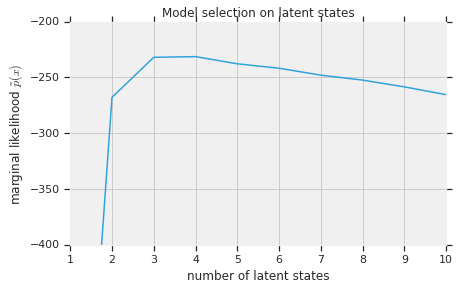

In [0]:
num_states = np.arange(1, max_num_states+1)
plt.plot(num_states, total_log_prob_)
plt.ylim([-400, -200])
plt.ylabel("marginal likelihood $\\tilde{p}(x)$")
plt.xlabel("number of latent states")
plt.title("Model selection on latent states")

Examining the likelihoods, we see that the (approximate) marginal likelihood prefers a three- or four-state model (the specific ordering may vary between runs of this notebook). This seems quite plausible -- the 'true' model had four states, but from just looking at the data it's hard to rule out a three-state explanation.


We can also extract the rates fit for each candidate model:

In [0]:
for i, learned_model_rates_ in enumerate(learned_rates_):
  print("rates for {}-state model: {}".format(i+1, learned_model_rates_[:i+1]))

rates for 1-state model: [ 32.28687668]
rates for 2-state model: [  4.42810249  45.73866272]
rates for 3-state model: [ 18.0173893   46.86778259   2.95784855]
rates for 4-state model: [ 18.01735115  39.34053802  49.0630722    2.95801497]
rates for 5-state model: [ 39.29985428  49.01822281  49.01839828  18.01650047   2.95783567]
rates for 6-state model: [ 39.28063965  49.01509094  49.01533508   2.91552424   2.91553688
  18.01659012]
rates for 7-state model: [ 39.2408371   49.03346252  49.03365326   2.91554856   2.91553354
  18.01661301  39.24029541]
rates for 8-state model: [ 39.25536346  48.97928619  48.97933197   2.87192702   2.87377501
  18.01662445  48.97929764   2.87365103]
rates for 9-state model: [ 39.20381927  49.28605652  48.99845123   2.87227631   2.87389278
  18.01664162  49.02532959   2.87364078  39.20324707]
rates for 10-state model: [ 39.19308853  48.99163055  48.99180603  17.65075874   2.91572142
  17.65078926  48.99168777   2.91570425  39.19294739  17.65077209]


### Extensions

The models in this notebook could be straightforwardly extended in many ways. For example:

- allowing latent states to have different probabilities (some states may be common vs rare)
- allowing nonuniform transitions between latent states (e.g., to learn that a machine crash is usually followed by a system reboot is usually followed by a period of good performance, etc.)
- other emission models, e.g. `NegativeBinomial` to model varying dispersions in count data, or continous distributions such as `Normal` for real-valued data.
